<div>
<img src='https://www.sharif.edu/documents/20124/0/logo-fa-IR.png' alt="SUT logo" width=130 height=130 align=left class="saturate">

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<!-- <font color=0F5298 size=7> -->
<font color=0F5298 size=6>
    Deep Generative Models <br> <br>
<!-- <font color=2565AE size=5> -->
<font size=5>
    Computer Engineering Department <br>
    Spring 2024 <br> <br>
<font color=606060 size=5>
    Homework 3: Practical - GAN <br> <br>
<font color=686880 size=4>
    TAs: Ali Salesi

___

### Full Name : Amir Mohammad Babaei
### Student Number : 402212399
___

## Note
GANs are sometimes hard to train and sensitive to hyperparameter changes. so the config classes are ready for you to make it easier. You are more than welcome to change the hyperparameters and play with different settings to get better results. Other cells that do not have `# TODO` tags are not to be changed.

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from tqdm import trange
from IPython.display import clear_output

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# GAN

## Initialization

In [3]:
class Config:
    D_OPTIMIZER_LR = 0.0002
    G_OPTIMIZER_LR = 0.0002
    BATCH_SIZE = 128
    LATENT_DIM = 100
    MNIST_DIM = 28, 28
    EPOCHS = 200
    PLOT_SIZE = 6, 6

Load MNIST Dataset using PyTorch and Normalize using 0.5 mean and 0.5 std.

In [4]:
# Define the transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4672114.35it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 133726.29it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1274866.40it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9247829.50it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Architecture

Design your GAN generator and discriminator.

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(Config.LATENT_DIM, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, int(Config.MNIST_DIM[0] * Config.MNIST_DIM[1])),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *Config.MNIST_DIM)
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(int(Config.MNIST_DIM[0] * Config.MNIST_DIM[1]), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

In [6]:
G = Generator().to(device)
D = Discriminator().to(device)

In [7]:
criterion = nn.BCELoss()
D_optimizer = torch.optim.Adam(D.parameters(), lr=Config.D_OPTIMIZER_LR)
G_optimizer = torch.optim.Adam(G.parameters(), lr=Config.G_OPTIMIZER_LR)

## Training

Write the training loop for the discriminator

In [8]:
def D_train(real_imgs):
    D_optimizer.zero_grad()

    # Adversarial ground truths
    valid = torch.ones(real_imgs.size(0), 1, device=device)
    fake = torch.zeros(real_imgs.size(0), 1, device=device)

    # Measure discriminator's ability to classify real from generated samples
    real_loss = criterion(D(real_imgs), valid)

    # Sample noise as generator input
    z = torch.randn(real_imgs.size(0), Config.LATENT_DIM, device=device)

    # Generate a batch of images
    gen_imgs = G(z)

    # Measure discriminator's ability to classify real from generated samples
    fake_loss = criterion(D(gen_imgs.detach()), fake)

    # Total discriminator loss
    d_loss = (real_loss + fake_loss) / 2

    d_loss.backward()
    D_optimizer.step()

    return d_loss.item()

Write the training loop for the generator

In [9]:
def G_train():
    G_optimizer.zero_grad()

    # Adversarial ground truths
    valid = torch.ones(Config.BATCH_SIZE, 1, device=device)

    # Sample noise as generator input
    z = torch.randn(Config.BATCH_SIZE, Config.LATENT_DIM, device=device)

    # Generate a batch of images
    gen_imgs = G(z)

    # Loss measures generator's ability to fool the discriminator
    g_loss = criterion(D(gen_imgs), valid)

    g_loss.backward()
    G_optimizer.step()

    return g_loss.item()

Generate images from the generator for the plot

In [10]:
def plot_generated():
    with torch.no_grad():
        # Sample noise as generator input
        z = torch.randn(Config.PLOT_SIZE[0] * Config.PLOT_SIZE[1], Config.LATENT_DIM, device=device)

        # Generate a batch of images
        gen_imgs = G(z).cpu()

        # Rescale images from [-1, 1] to [0, 1]
        gen_imgs = (gen_imgs + 1) / 2

        _, axes = plt.subplots(Config.PLOT_SIZE[0], Config.PLOT_SIZE[1], figsize=(Config.PLOT_SIZE[1], Config.PLOT_SIZE[0]))
        for i, ax in enumerate(axes.flat):
            imgs = gen_imgs[i].view(Config.MNIST_DIM[0], Config.MNIST_DIM[1])
            ax.imshow(imgs, cmap='gray')
            ax.axis('off')

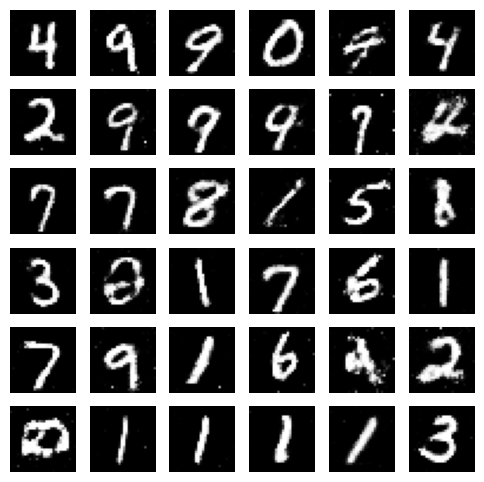

D_loss: 0.586, G_loss: 1.090: 100%|█████████▉| 199/200 [52:13<00:15, 15.60s/it]

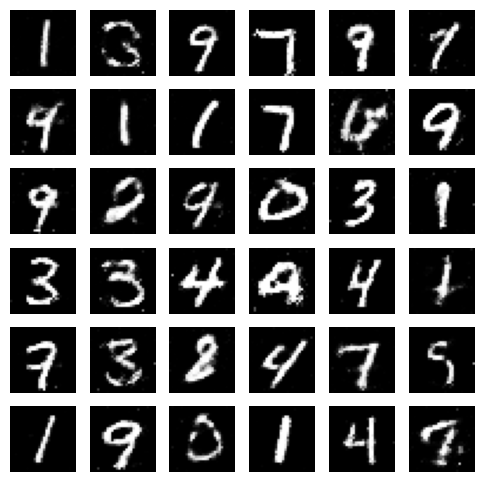

D_loss: 0.585, G_loss: 1.084: 100%|██████████| 200/200 [52:29<00:00, 15.75s/it]


In [ ]:
pbar = trange(Config.EPOCHS)
for epoch in pbar:
    D_losses = []
    G_losses = []
    for imgs, _ in trainloader:
        imgs = imgs.to(device, non_blocking=True)
        D_losses.append(D_train(imgs))
        G_losses.append(G_train())
    plot_generated()
    clear_output(wait=True)
    plt.show()
    pbar.set_description(f'D_loss: {torch.mean(torch.FloatTensor(D_losses)):.03f}, G_loss: {torch.mean(torch.FloatTensor(G_losses)):.03f}')

# Conditional GAN

## Initialization

In [ ]:
class Config:
    D_OPTIMIZER_LR = 0.0002
    G_OPTIMIZER_LR = 0.0002
    BATCH_SIZE = 128
    LATENT_DIM = 100
    MNIST_DIM = 28, 28
    EPOCHS = 200
    PLOT_SIZE = 10, 6
    CLASS_COUNT = 10

## Architecture

Design the generator and the discriminator for the conditional GAN

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(10, 10)  # Embedding for 10 classes

        self.model = nn.Sequential(
            nn.Linear(Config.LATENT_DIM + 10, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, int(Config.MNIST_DIM[0] * Config.MNIST_DIM[1])),
            nn.Tanh()
        )

    def forward(self, z, labels):
        # Concatenate the noise and the label embedding
        c = self.label_emb(labels)
        input = torch.cat((z, c), -1)
        img = self.model(input)
        img = img.view(img.size(0), *Config.MNIST_DIM)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(10, 10)  # Embedding for 10 classes

        self.model = nn.Sequential(
            nn.Linear(int(Config.MNIST_DIM[0] * Config.MNIST_DIM[1]) + 10, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        # Concatenate the image and the label embedding
        c = self.label_emb(labels)
        x = x.view(x.size(0), -1)
        input = torch.cat((x, c), -1)
        validity = self.model(input)
        return validity

In [ ]:
G = Generator().to(device)
D = Discriminator().to(device)

In [ ]:
criterion = nn.BCELoss()
D_optimizer = optim.Adam(D.parameters(), lr=Config.D_OPTIMIZER_LR)
G_optimizer = optim.Adam(G.parameters(), lr=Config.G_OPTIMIZER_LR)

## Training

Design your conditional GAN training loop

In [ ]:
def D_train(real_imgs, labels):
    D_optimizer.zero_grad()

    # Adversarial ground truths
    valid = torch.ones(real_imgs.size(0), 1, device=device)
    fake = torch.zeros(real_imgs.size(0), 1, device=device)

    # Measure discriminator's ability to classify real from generated samples
    real_loss = criterion(D(real_imgs, labels), valid)

    # Sample noise as generator input
    z = torch.randn(real_imgs.size(0), Config.LATENT_DIM, device=device)

    # Generate a batch of images
    gen_imgs = G(z, labels)

    # Measure discriminator's ability to classify real from generated samples
    fake_loss = criterion(D(gen_imgs.detach(), labels), fake)

    # Total discriminator loss
    d_loss = (real_loss + fake_loss) / 2

    d_loss.backward()
    D_optimizer.step()

    return d_loss.item()

In [ ]:
def G_train(labels):
    G_optimizer.zero_grad()

    # Batch-size based on the input labels
    B = labels.shape[0]

    # Adversarial ground truths
    valid = torch.ones(B, 1, device=device)

    # Sample noise as generator input
    z = torch.randn(B, Config.LATENT_DIM, device=device)

    # Generate a batch of images
    gen_imgs = G(z, labels)

    # Loss measures generator's ability to fool the discriminator
    g_loss = criterion(D(gen_imgs, labels), valid)

    g_loss.backward()
    G_optimizer.step()

    return g_loss.item()

In [ ]:
def plot_generated():
    with torch.no_grad():
        # Sample noise as generator input
        z = torch.randn(Config.PLOT_SIZE[0] * Config.PLOT_SIZE[1], Config.LATENT_DIM, device=device)
        labels = torch.tensor([i for i in range(Config.PLOT_SIZE[0]) for j in range(Config.PLOT_SIZE[1])], device=device)

        # Generate a batch of images
        gen_imgs = G(z, labels).cpu()

        # Rescale images from [-1, 1] to [0, 1]
        gen_imgs = (gen_imgs + 1) / 2

        _, axes = plt.subplots(Config.PLOT_SIZE[0], Config.PLOT_SIZE[1], figsize=(Config.PLOT_SIZE[1], Config.PLOT_SIZE[0]))
        for i, ax in enumerate(axes.flat):
            imgs = gen_imgs[i].view(Config.MNIST_DIM[0], Config.MNIST_DIM[1])
            ax.imshow(imgs, cmap='gray')
            ax.axis('off')

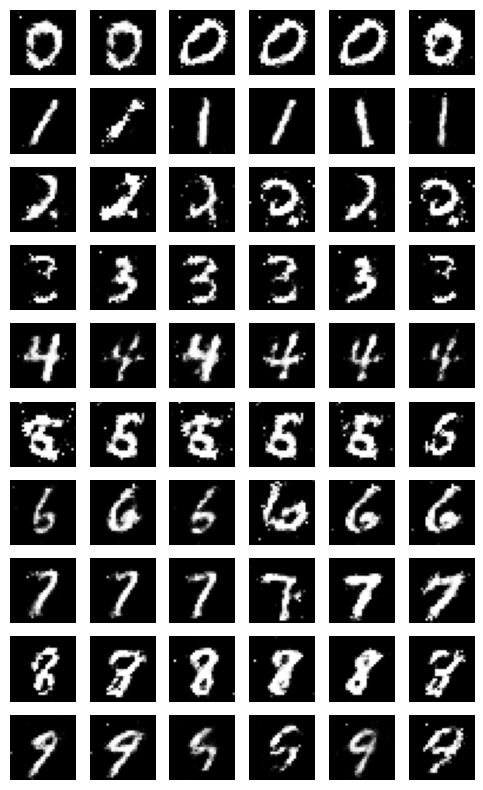

D_loss: 0.425, G_loss: 1.808: 100%|██████████| 200/200 [1:08:00<00:00, 20.40s/it]


In [ ]:
pbar = trange(Config.EPOCHS)
for epoch in pbar:
    D_losses = []
    G_losses = []
    for imgs, labels in trainloader:
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        D_losses.append(D_train(imgs, labels))
        G_losses.append(G_train(labels))
    plot_generated()
    clear_output(wait=True)
    plt.show()
    pbar.set_description(f'D_loss: {torch.mean(torch.FloatTensor(D_losses)):.03f}, G_loss: {torch.mean(torch.FloatTensor(G_losses)):.03f}')

# WGAN

## Initialization

In [ ]:
class Config:
    LR = 3e-4
    WEIGHT_CLIPPING = 0.01
    BATCH_SIZE = 128
    CRITIC_ITERS = 5
    EPOCHS = 250
    PLOT_SIZE = 6, 6

In [ ]:
class Standardize:
    def __call__(self, img):
        return img.float() * 2. - 1.

Load CIFAR10 from PyTorch with Standardize transformation

In [ ]:
# Load CIFAR10 from PyTorch with Standardize transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    Standardize()
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

## Architecture

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.ConvTranspose2d(100, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        r"""Defines the computation performed at every call.

        Args:
            z (tensor): z tensor into the calculation.

        Returns:
            A four-dimensional vector (NCHW).
        """
        out = self.model(z)
        return out

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(256, 1, 4, 1, 0),
        )

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        r""" Defines the computation performed at every call.

        Args:
            input (tensor): input tensor into the calculation.

        Returns:
            A four-dimensional vector (NCHW).
        """
        out = self.model(input)
        out = torch.flatten(out)
        return out

In [ ]:
G = Generator().to(device)
D = Discriminator().to(device)

In [ ]:
# !pip install torch-summary
from torchsummary import summary

summary(G, (100, 1, 1))

In [ ]:
summary(D, (3, 32, 32))

In [ ]:
D_optimizer = torch.optim.Adam(D.parameters(), lr=Config.LR, betas=(0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=Config.LR, betas=(0.5, 0.999))

## Training

Design WGAN training loop with weight clipping (or gradient penalty if you want to)

In [ ]:
def calculate_gradient_penalty(model, real_images, fake_images, device):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake data
    alpha = torch.randn((real_images.size(0), 1, 1, 1), device=device)
    # Get random interpolation between real and fake data
    interpolates = (alpha * real_images + ((1 - alpha) * fake_images)).requires_grad_(True)

    model_interpolates = model(interpolates)
    grad_outputs = torch.ones(model_interpolates.size(), device=device, requires_grad=False)

    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=model_interpolates,
        inputs=interpolates,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = torch.mean((gradients.norm(2, dim=1) - 1) ** 2)
    return gradient_penalty

In [ ]:
def D_train(real_imgs):
    ##############################################
    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    ##############################################
    real_imgs = real_imgs.to(device)
    batch_size = real_imgs.size(0)

    # Train with real
    real_output = D(real_imgs)
    errD_real = torch.mean(real_output)
    # D_x = real_output.mean().item()

    # Generate fake image batch with G
    z = torch.randn(batch_size, 100, 1, 1, device=device)
    fake_images = G(z)

    # Train with fake
    fake_output = D(fake_images.detach())
    errD_fake = torch.mean(fake_output)
    # D_G_z1 = fake_output.mean().item()

    # Calculate W-div gradient penalty
    gradient_penalty = calculate_gradient_penalty(D, real_imgs.data, fake_images.data, device)

    # Set discriminator gradients to zero.
    D_optimizer.zero_grad()

    # Add the gradients from the all-real and all-fake batches
    errD = -errD_real + errD_fake + gradient_penalty * 10
    errD.backward()
    D_optimizer.step()

    return errD.item()

In [ ]:
def G_train():
    ##############################################
    # (2) Update G network: maximize log(D(G(z)))
    ##############################################
    # Set generator gradients to zero
    G_optimizer.zero_grad()

    # Generate fake image batch with G
    batch_size = Config.BATCH_SIZE
    z = torch.randn(batch_size, 100, 1, 1, device=device)

    fake_images = G(z)
    fake_output = D(fake_images)
    errG = -torch.mean(fake_output)
    # D_G_z2 = fake_output.mean().item()

    errG.backward()
    G_optimizer.step()

    return errG.item()

In [ ]:
import matplotlib.pyplot as plt

def plot_generated():
    with torch.no_grad():
        z = torch.randn(Config.PLOT_SIZE[0] * Config.PLOT_SIZE[1], 100, 1, 1, device=device)
        gen_imgs = G(z).cpu()

        fig, axes = plt.subplots(Config.PLOT_SIZE[0], Config.PLOT_SIZE[1], figsize=(Config.PLOT_SIZE[1], Config.PLOT_SIZE[0]))
        for i, ax in enumerate(axes.flat):
            ax.imshow((gen_imgs[i].permute(1, 2, 0) + 1) / 2)
            ax.axis('off')

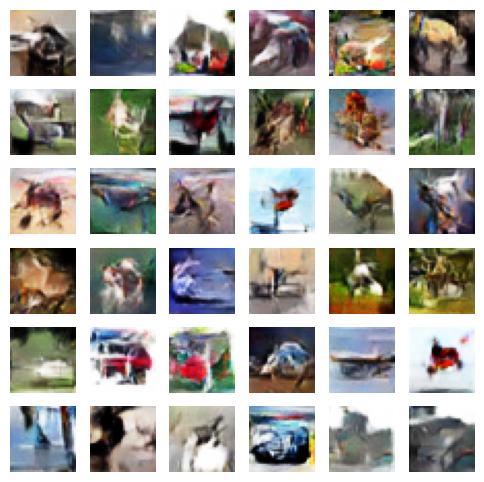

D_loss: -2693.265, G_loss: -35.067: 100%|██████████| 250/250 [1:10:05<00:00, 16.82s/it]


In [24]:
from tqdm import trange
from IPython.display import clear_output

pbar = trange(Config.EPOCHS)
for epoch in pbar:
    D_losses = []
    G_losses = []
    for i, (imgs, _) in enumerate(trainloader):
        D_losses.append(D_train(imgs))
        if i % Config.CRITIC_ITERS == 0:
            G_losses.append(G_train())
    plot_generated()
    clear_output(wait=True)
    plt.show()
    pbar.set_description(f'D_loss: {torch.mean(torch.FloatTensor(D_losses)):.03f}, G_loss: {torch.mean(torch.FloatTensor(G_losses)):.03f}')